# Prediction of U.S. Corn Future Prices using Machine Learning - Preprocessing

Table of Contents: <br>
1. Data Preprocessing<br>
    1.1 Corn Future Prices <br>
    1.2 Climate Data <br>
    1.3 CGM Output Data <br>
    1.4 NDVI Data <br>
2. Merging Data <br>
    2.1 CGM Dataset <br>
    2.2 Combined Dataset <br>
    2.3 Separate Dataset <br>

In [1]:
# # LIBRARY INSTALLATION:
# import sys

# !{sys.executable} -m pip install tensorflow
# !{sys.executable} -m pip install keras
# !{sys.executable} -m pip install statsmodels
# !{sys.executable} -m pip install scikit-learn
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install xlrd

In [2]:
# Importing useful packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style, rcParams
import datetime
import warnings
from platform import python_version
import os

# Importing self-written module
%run AA_Functions.ipynb

In [3]:
print('Current Directory:', os.getcwd()) # all documents should be under this directory
warnings.filterwarnings("ignore") # suppress all warnings, can be commented out
style.use('seaborn-whitegrid') # set plot style
rcParams.update({'font.size': 10}) # set plot font size

Current Directory: C:\Users\nickb\Dropbox\Bachelorarbeit\Bischofberger_Nick_BA\Code


## 1. Data Preprocessing

### 1.1 Corn Future Prices

In [4]:
# Importing price data with dates as index
df_C1 = pd.read_csv('Data/01_Corn_Futures_Price_C1_1999_2019.csv', parse_dates=True, index_col=0)
# Extract closing price
df_last = df_C1[['PX_Last']]
# Sort by dates/index
df_last.sort_index(inplace=True, ascending=True)
# Drop NaN values in PX_Last column: 24 missing values are dropped, because only few NaN
print('Missing values BEFORE dropping NaN:', df_last['PX_Last'].isnull().sum())
df_last.dropna(inplace=True) 
print('Missing values AFTER dropping NaN:', df_last['PX_Last'].isnull().sum())
print('Count of closing price data:', df_last.shape[0])

Missing values BEFORE dropping NaN: 24
Missing values AFTER dropping NaN: 0
Count of closing price data: 5247


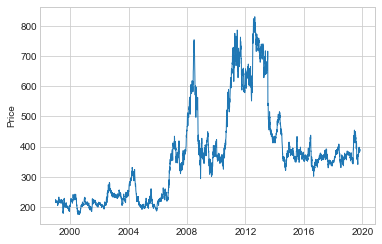

In [5]:
# Plot trajectory of corn futures price
plt.plot(df_last,linewidth=1)
plt.ylabel('Price')
plt.savefig('Graphics/Corn_Price_2001_2018.png', dpi=1000, bbox_inches='tight')

### 1.2 Climate Data

In [6]:
# Import precipitation data by state
precipitation = pd.read_excel('Data/05_Precipitation_2000_2018.xlsx', header=0)
# Import max. temperature data by state
tmax = pd.read_excel('Data/06_Tmax_2000_2018.xlsx', header=0)
# Import min. temperature data by state
tmin = pd.read_excel('Data/07_Tmin_2000_2018.xlsx', header=0)
# State production values (ordered alphabatically)
production = pd.read_csv('Data/AA_Production_2018_18States.csv')

In [7]:
# Extract corn production values from file for all 18 states 
prod_values = production[['Value']].values.tolist()
prod_values = [item for sublist in prod_values for item in sublist]
prod_sum = np.array(prod_values).sum()
prod_values = [i/prod_sum for i in prod_values] #dividing values by 1'000'000 for better overview

In [8]:
# Weight precipitation by production values of 2018
prec_mul = precipitation.multiply(prod_values)
tmax_mul = tmax.multiply(prod_values)
tmin_mul = tmin.multiply(prod_values)
# Calculate weighted average for all 18 states
prec_mul['weighted_average'] = prec_mul.sum(axis=1)
tmax_mul['weighted_average'] = tmax_mul.sum(axis=1)
tmin_mul['weighted_average'] = tmin_mul.sum(axis=1)
# Extract weighted average column
prec = prec_mul[['weighted_average']]
tmax = tmax_mul[['weighted_average']]
tmin = tmin_mul[['weighted_average']]

In [9]:
# Create date column
start = datetime.datetime.strptime("2000-01-01", "%Y-%m-%d")
end = datetime.datetime.strptime("2019-01-01", "%Y-%m-%d")
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]
dates = pd.DataFrame(date_generated)

In [10]:
# Remove all 29th of February, because they are also deleted in the climate dataset
for i in range(2000, 2019, 4):
    dates = dates[dates[0] != '{0:}-02-29'.format(str(i))]

In [11]:
# Add dates to weighted average data
climate_data = pd.concat([prec.reset_index(drop=True), dates.reset_index(drop=True)], axis= 1)
climate_data['tmax18'] = tmax
climate_data['tmin18'] = tmin

In [12]:
# Rename columns
climate_data.rename(columns={0:'Date', 'weighted_average':'precipitation18'}, inplace=True)
# Set date as index
climate_data.set_index('Date', inplace=True)

In [13]:
# Shift all climate data by 10 days
climate_data = climate_data.shift(-10, axis=0)
print("Missing values:", climate_data.isnull().sum().sum())
climate_data.dropna(inplace=True)

Missing values: 30


In [14]:
# Calculate moving average of climate data for more robustness. Then drop na
climate_MA = climate_data.rolling(window=30).mean()
climate_MA.dropna(inplace=True)

In [15]:
# Export data as CSV for debugging
climate_MA.to_csv(path_or_buf='Data/Preprocessed_Data/03_Climate_Variables_2001_2018.csv')

### 1.3 CGM Output Data

Data provied by Stefanos Mystakidis as part of the CGM output. <br> <br>
7 States  = Illinois, Indiana, Kansas, Nebraska, Kentucky, Tennessee, Missouri <br>
18 States = 7 States + Iowa, Minnesota, Michigan, Wisconsin, South Dakota, Oklahoma, Arkansas, North Carolina, Virginia, West Virginia, Ohio

In [16]:
# Importing Yield and AGB Data for 7 States Average: 
xls1 = pd.ExcelFile('Data/03_Yield_AGB_2001_2018_7States.xlsx')
yield7 = pd.read_excel(xls1, 'Yield (tonnes per ha) 7States', index_col=0, parse_dates=True)
agb7 = pd.read_excel(xls1, 'AGB (tonnes per ha) 7States', index_col=0, parse_dates=True)

In [17]:
# Importing Yield and AGB Data for 18 States Average: 
xls2 = pd.ExcelFile('Data/02_Yield_AGB_2001_2018_18States.xlsx')
yield18 = pd.read_excel(xls2, 'Yield (tonnes per ha) WholeDoma',index_col=0, parse_dates=True)
agb18 = pd.read_excel(xls2, 'AGB (tonnes per ha) WholeDomain', index_col=0, parse_dates=True)

Rearrange all 4 data subset as 1 column, then set date as index

In [18]:
# Apply function to all data subsets
yield7 = yield_agb_arranger(data=yield7, name='Yield7')
agb7 = yield_agb_arranger(data=agb7, name='AGB7')
yield18 = yield_agb_arranger(data=yield18, name='Yield18')
agb18 = yield_agb_arranger(data=agb18, name='AGB18')

In [19]:
# Merge all data subsets into one DataFrame
df_yield = pd.merge(yield18, yield7,how='outer', on='Date')
df_agb = pd.merge(agb18, agb7, how='outer', on='Date')
df_ya = pd.merge(df_yield, df_agb, how='outer', on = 'Date')

In [20]:
# Shift data by 14 days
df_ya_shift = df_ya.shift(-14, axis=0)
df_ya_shift.dropna(inplace=True)# for debugging

In [21]:
# Save merged yield and AGB data as CSV
df_ya_shift.to_csv(path_or_buf='Data/Preprocessed_Data/01_Yield_AGB_2001_2018.csv')

### 1.4 NDVI Data

NDVI data downloaded from https://glam1.gsfc.nasa.gov/. Accessed: 22/01/2020 <br>
The NDVI for an 18-state average is used. <br>
States are the same as in Yield18 and AGB18.

In [22]:
# Load NDVI data, set date as index and sort index
df_ndvi = pd.read_csv('Data/04_NDVI_2001_2018.csv', header=15)
df_ndvi['Date'] = pd.to_datetime(df_ndvi['START DATE'])
df_ndvi.set_index('Date', inplace=True)
df_ndvi.sort_index(inplace=True)
# Get relevant columns
ndvi = df_ndvi[['MEAN VALUE', 'MIN VALUE', 'MAX VALUE']]

In [23]:
# Create column for replication of each NDVI value
# Normally every NDVI value is repeated 8 times, because data is 
# provided as 8 day-average and we need daily data
ndvi['RTimes'] = 8
# At the end of every year (last days of Dec) only 5 day-averages are taken
ndvi.iat[45,3] = 5
for i in range(2, 19):
    ndvi.iat[46*i-1,3] = 5
# In leap years, at the end of every year only 6 day-averages are taken
for i in range(4,20,4):
    ndvi.iat[i*46-1,3] = 6
# Now replicate the date with the RTimes column value
ndvi_rep = ndvi.loc[ndvi.index.repeat(ndvi.RTimes)]

In [24]:
# Add correct dates to NDVI data: from 2001-01-01 to 2018-12-31
start = datetime.datetime.strptime("2001-01-01", "%Y-%m-%d")
end = datetime.datetime.strptime("2019-01-01", "%Y-%m-%d")
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]
dates = pd.DataFrame(date_generated)
ndvi = pd.concat([ndvi_rep.reset_index(drop=True), dates.reset_index(drop=True)], axis= 1)
# Rename columns
ndvi.rename(columns={0:'Date', 'MEAN VALUE':'NDVI18'}, inplace=True)
# Set date as index
ndvi.set_index('Date', inplace=True)

In [25]:
# Calculate 30-day moving average
ndvi = ndvi.rolling(window=30).mean()
ndvi.dropna(inplace=True)
ndvi = ndvi[['NDVI18']]

In [26]:
ndvi # for debugging

,NDVI18
Date,
2001-01-30,0.356333
2001-01-31,0.355667
2001-02-01,0.355000
2001-02-02,0.354200
2001-02-03,0.353400
...,...
2018-12-27,0.392700
2018-12-28,0.391667
2018-12-29,0.390633


In [27]:
# Export data as CSV for debugging
ndvi.to_csv(path_or_buf='Data/Preprocessed_Data/02_NDVI_2001_2018.csv')

## 2. Merging Data

### 2.1 CGM Dataset

Merging Price with Yield & AGB dataset

In [28]:
# Merge price with yield and AGB data on date/index;
# only taking the inner values, because stock exchange is closed on some days
df_pya = pd.merge(df_last, df_ya_shift, how='inner', on='Date')
df_pya.rename(columns={'PX_Last': 'Price'},inplace=True)

In [29]:
# Checking for NaN values again, missing values are dropped, because only a few.
print('Missing value count:',df_pya.isnull().sum().sum())

Missing value count: 0


Merging Price, Yield & AGB with NDVI dataset 

In [30]:
# Merge on date/index only taking the inner values
df_pyan = pd.merge(df_pya, ndvi, how='inner', on='Date')

In [31]:
df_pyan

,Price,Yield18,Yield7,AGB18,AGB7,NDVI18
Date,,,,,,
2001-01-30,209.25,7.260893,7.417578,15.18194,15.83152,0.356333
2001-01-31,209.00,7.260893,7.417578,15.18194,15.83152,0.355667
2001-02-01,211.00,7.260893,7.417578,15.18194,15.83152,0.355000
2001-02-02,213.00,7.260893,7.417578,15.18194,15.83152,0.354200
2001-02-05,212.00,7.260893,7.417578,15.18194,15.83152,0.351800
...,...,...,...,...,...,...
2018-12-11,375.00,7.667130,6.798717,15.92238,14.89940,0.411033
2018-12-12,376.25,7.667130,6.798717,15.92238,14.89940,0.409600
2018-12-13,375.50,7.667130,6.798717,15.92238,14.89940,0.408167


In [32]:
# Export as CSV file for further use in "2. Machine Learning.ipynb"
df_pyan.to_csv(path_or_buf='Data/Preprocessed_Data/AA_CGM_Model_2001_2018.csv')

### 2.2 Combined Dataset

In [33]:
# Combining all variables into one dataset
df_pyanp = pd.merge(df_pyan, climate_MA, how='inner', on='Date') # All variables

In [34]:
df_pyanp.describe()

,Price,Yield18,Yield7,AGB18,AGB7,NDVI18,precipitation18,tmax18,tmin18
count,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000,4503.000000
mean,385.401066,5.151423,4.984527,11.307588,11.115332,0.516271,2.672323,16.398831,4.473643
std,156.706211,3.491018,3.365100,6.418378,6.207356,0.141805,1.227452,10.521476,9.764159
min,184.500000,0.000000,0.000000,0.000000,0.000000,0.337067,0.299927,-4.734227,-16.257518
25%,243.000000,0.252509,0.275830,5.887119,6.832349,0.377733,1.701544,6.556096,-4.330638
50%,362.500000,6.990645,6.561862,14.881260,14.584940,0.493400,2.532084,18.132939,4.939066
75%,431.375000,8.028634,7.493155,16.004459,15.530450,0.658933,3.436631,26.464951,14.024826
max,831.250000,9.371599,9.320115,17.603029,17.345230,0.730333,7.164794,34.120102,20.650149


In [35]:
df_pyanp.to_csv(path_or_buf='Data/Preprocessed_Data/AC_Combined_Model_2001_2018.csv')

### 2.3 Separate Dataset

In [36]:
# No CGM dataset creation
df_pnptt = df_pyanp[['Price', 'NDVI18', 'precipitation18', 'tmax18', 'tmin18']]

In [37]:
df_pnptt.head()

,Price,NDVI18,precipitation18,tmax18,tmin18
Date,,,,,
2001-01-30,209.25,0.356333,1.922475,0.998079,-8.752397
2001-01-31,209.00,0.355667,2.113111,0.769787,-9.093101
2001-02-01,211.00,0.355000,2.081987,0.499550,-9.434367
2001-02-02,213.00,0.354200,2.075079,0.391470,-9.658767
2001-02-05,212.00,0.351800,2.127651,0.360266,-9.979603


In [38]:
# Export as CSV file for further use in "2. Machine Learning.ipynb"
df_pnptt.to_csv(path_or_buf='Data/Preprocessed_Data/AB_Separate_Model_2001_2018.csv')